In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
import seaborn as sn
import numpy as np
import pandas as pd
import math
import datetime
import platform
import os

In [3]:
class_names = [str(i) for i in range(10)]
# class_names.append('a')
# class_names.append('b')

In [4]:
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     IMAGE_DIRECTORY,
#     labels='inferred',
#     label_mode='int',
#     class_names=class_names,
#     color_mode='grayscale',
#     image_size=(128, 128),
#     shuffle=True,
#     seed=123,
#     interpolation='bilinear',
#     follow_links=False,
#     data_format=None,
#     verbose=True
# )
# train_ds, test_ds = tf.keras.utils.split_dataset(dataset, left_size=0.8)
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     IMAGE_DIRECTORY,
#     labels='inferred',
#     label_mode='int',
#     class_names=[str(i) for i in range(10)],
#     color_mode='grayscale',
#     image_size=(128, 128),
#     shuffle=True,
#     seed=123,
#     validation_split=0.8,
#     subset="training",
#     interpolation='bilinear',
#     follow_links=False,
#     data_format=None,
#     verbose=False
# )
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     IMAGE_DIRECTORY,
#     labels='inferred',
#     label_mode='int',
#     class_names=[str(i) for i in range(10)],
#     color_mode='grayscale',
#     image_size=(128, 128),
#     shuffle=True,
#     seed=123,
#     validation_split=0.2,
#     subset="validation",
#     interpolation='bilinear',
#     follow_links=False,
#     data_format=None,
#     verbose=False
# )

In [5]:
IMAGE_DIRECTORY = "../Datasets/HandWritten-Nist/dataset"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
	IMAGE_DIRECTORY,
	labels="inferred",
	label_mode="categorical", # one-hot encoding stuff
	image_size=(128, 128),
	shuffle=True,
	color_mode="grayscale"
)

# Split to train and test 80/20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.take(val_size)


Found 425122 files belonging to 47 classes.


I0000 00:00:1732025138.161933   59361 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732025138.401572   59361 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732025138.401663   59361 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732025138.404653   59361 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732025138.404752   59361 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [6]:
# Normalize the dataset prior to the model

def normalize(image, label):
	image = tf.cast(image, tf.float32) / 255.0
	return image, label

train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)

In [7]:
# # Configuring the dataset for performance
# # Enable caching and prefetching (overlap preprocessing and model execution while training)
# AUTOTUNE = tf.data.AUTOTUNE

# # Set up a pre-processing function. It is just going to be normalizing here, but
# # that hopefully should save time later?
# def preprocess_image(image, label):
# 	image = image / 255.0
# 	return image, label

# # Cache to disk instead of memory because we got some large datasets
# dataset = dataset.cache('/tmp/dataset_cache')

# # Apply preprocessing
# # dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# # Prefetching..? Gotta be honest, this seems to help but idk how considering all
# # the images are local
# dataset = dataset.prefetch(buffer_size=2)

# train_ds = dataset.shuffle(1000)

# # train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# # train_ds = dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# # val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache('/tmp/dataset_cache')
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.prefetch(buffer_size=2)

In [9]:
# print(train_dataset.class_names)
# labels = tf.keras.utils.to_categorical()

In [14]:
model = tf.keras.models.Sequential()
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 1

# # Standardize. Bring it down from 0..255 to [0,1] range
# model.add(tf.keras.layers.Rescaling(
# 	scale=1./255,
#     input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
# ))

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dropout(0.2))

# Output layer
model.add(tf.keras.layers.Dense(
    units=47,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 8)    │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,983 (6.61 MB)

 Trainable params: 1,731,983 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile the model

# Uses Adam. Adam works by
# - Keeping track of a history of gradients as opposed to just the current
#   gradient
# - It uses an adaptive learning rate based on that gradient history Adam is

# It also just generally efficient and works well for our use case (ChatGPT
# mentions good for computer vision tasks which is kind of what we are doing)

# We might try testing this with stochastic gradient descent instead because
# that is what we learned in class. We could use that as a storytelling aspect
# for the professor

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy,
    # loss=tf.keras.losses.CTC,
    metrics=['accuracy']
)

In [17]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    train_dataset,
    # y_train_re,
    epochs=5,
    # validation_data=(x_validation_normalized, y_validation_re),
    validation_data=val_dataset
    # callbacks=[tensorboard_callback]
)

print("The model has successfully trained")

Epoch 1/10


I0000 00:00:1732025397.530369   59845 service.cc:146] XLA service 0x7f8694005b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732025397.530509   59845 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6


    3/10628 ━━━━━━━━━━━━━━━━━━━━ 1:06 6ms/step - accuracy: 0.0191 - loss: 3.8843      

I0000 00:00:1732025401.220342   59845 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10628/10628 ━━━━━━━━━━━━━━━━━━━━ 2277s 198ms/step - accuracy: 0.4708 - loss: 1.9498 - val_accuracy: 0.8223 - val_loss: 0.5850
Epoch 2/10
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 844s 75ms/step - accuracy: 0.7814 - loss: 0.7086 - val_accuracy: 0.8541 - val_loss: 0.4704
Epoch 3/10
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 849s 76ms/step - accuracy: 0.8182 - loss: 0.5872 - val_accuracy: 0.8662 - val_loss: 0.4228
Epoch 4/10
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 845s 75ms/step - accuracy: 0.8344 - loss: 0.5296 - val_accuracy: 0.8769 - val_loss: 0.3831
Epoch 5/10
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 869s 78ms/step - accuracy: 0.8469 - loss: 0.4838 - val_accuracy: 0.8854 - val_loss: 0.3570
Epoch 6/10
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 847s 75ms/step - accuracy: 0.8563 - loss: 0.4506 - val_accuracy: 0.8901 - val_loss: 0.3366
Epoch 7/10
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 861s 77ms/step - accuracy: 0.8644 - loss: 0.4260 - val_accuracy: 0.8946 - val_loss: 0.3228
Epoch 8/10
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 855s 77ms/step - acc

In [18]:
# Access training loss and accuracy
train_loss = training_history.history['loss']
train_accuracy = training_history.history['accuracy']

# Access validation loss and accuracy (if validation data is provided)
val_loss = training_history.history.get('val_loss')
val_accuracy = training_history.history.get('val_accuracy')

# Print statistics for each epoch
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss[epoch]:.4f}, Training Accuracy: {train_accuracy[epoch]:.4f}")
    if val_loss and val_accuracy:
        print(f"  Validation Loss: {val_loss[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")

Epoch 1:
  Training Loss: 1.3007, Training Accuracy: 0.6288
  Validation Loss: 0.5850, Validation Accuracy: 0.8223
Epoch 2:
  Training Loss: 0.6665, Training Accuracy: 0.7934
  Validation Loss: 0.4704, Validation Accuracy: 0.8541
Epoch 3:
  Training Loss: 0.5698, Training Accuracy: 0.8224
  Validation Loss: 0.4228, Validation Accuracy: 0.8662
Epoch 4:
  Training Loss: 0.5153, Training Accuracy: 0.8381
  Validation Loss: 0.3831, Validation Accuracy: 0.8769
Epoch 5:
  Training Loss: 0.4737, Training Accuracy: 0.8498
  Validation Loss: 0.3570, Validation Accuracy: 0.8854
Epoch 6:
  Training Loss: 0.4420, Training Accuracy: 0.8590
  Validation Loss: 0.3366, Validation Accuracy: 0.8901
Epoch 7:
  Training Loss: 0.4190, Training Accuracy: 0.8656
  Validation Loss: 0.3228, Validation Accuracy: 0.8946
Epoch 8:
  Training Loss: 0.4001, Training Accuracy: 0.8709
  Validation Loss: 0.3039, Validation Accuracy: 0.9001
Epoch 9:
  Training Loss: 0.3811, Training Accuracy: 0.8758
  Validation Loss: 0

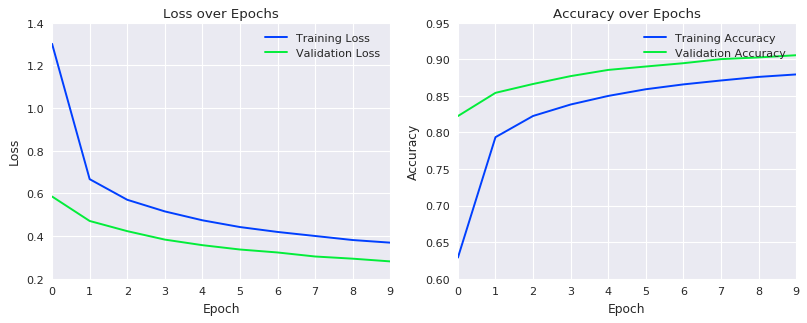

In [26]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-bright')

# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss')
if 'val_loss' in training_history.history:
    plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in training_history.history:
    plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
